##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# カスタム訓練：ウォークスルー

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/customization/custom_training_walkthrough.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

このチュートリアルでは、カスタムトレーニングループを使って機械学習モデルをトレーニングし、ペンギンを種類別に*分類*する方法を説明します。このノートブックでは、TensorFlow を使用して、次の項目を達成します。

1. データセットをインポートする
2. 単純な線形モデルを構築する
3. モデルをトレーニングする
4. モデルの有効性を評価する
5. トレーニングされたモデルを使用して予測を立てる

## TensorFlow プログラミング

このチュートリアルでは、次の TensorFlow プログラミングタスクを実演しています。

- [TensorFlow Datasets API](https://www.tensorflow.org/datasets/overview#load_a_dataset) を使ってデータをインポートする
- [Keras API](https://www.tensorflow.org/guide/keras/) を使ってモデルとレイヤーを構築する


## ペンギンの分類の問題

鳥類学者が、発見したペンギンを自動的に分類する方法を探していると仮定しましょう。機械学習では、ペンギンを静的に分類するためのアルゴリズムが多数用意されています。たとえば、高度な機械学習プログラムでは、写真を基にペンギンを分類できるものもあります。このチュートリアルで作成するモデルは、これよりも少しシンプルで、体重、フリッパーの長さ、くちばし、特に[ 嘴峰（しほう）](https://en.wikipedia.org/wiki/Beak#Culmen)の長さと幅に基づいてペンギンを分類します。

ペンギンには 18 種ありますが、このチュートリアルでは次の 3 種のみを分類してみることにしましょう。

- ヒゲペンギン
- ジェンツーペンギン
- アデリーペンギン

<table>
  <tr><td>     <img src="https://www.tensorflow.org/images/iris_three_species.jpg" alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">   </td></tr>
  <tr><td align="center"> <b>図 1.</b> <a href="https://en.wikipedia.org/wiki/Chinstrap_penguin">ヒゲペンギン</a>、<a href="https://en.wikipedia.org/wiki/Gentoo_penguin">ジェンツー</a>、および<a href="https://en.wikipedia.org/wiki/Ad%C3%A9lie_penguin">アデリー</a>ペンギン（イラスト: @allison_horst, CC BY-SA 2.0）。<br> </td></tr>
</table>

幸いにも、体重、フリッパーの長さ、くちばしの測定値とその他のデータで含む[334 羽のペンギンのデータセット](https://allisonhorst.github.io/palmerpenguins/)が調査チームによって既に作成されて共有されています。このデータセットは、[penguins](https://www.tensorflow.org/datasets/catalog/penguins) TensorFlow Dataset としても提供されています。 

## セットアップ

penguis データセットに使用する `tfds-nightly` パッケージをインストールします。`tfds-nightly` パッケージは毎晩リリースされる TensorFlow Datasets（TFDS）のバージョンです。TFDS の詳細については、[TensorFlow Datasets の概要](https://www.tensorflow.org/datasets/overview)をご覧ください。

In [2]:
!pip install -q tfds-nightly

次に、Colab メニューから **Runtime &gt; Restart Runtime** を選択して、Colab ランタイムを再起動します。

ランタイムを再起動せずに、チュートリアルを先に進めないでください。

TensorFlow と他に必要な Python モジュールをインポートします。 

In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

2022-12-15 02:49:54.529097: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 02:49:54.529227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 02:49:54.529239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TensorFlow version: 2.11.0
TensorFlow Datasets version:  4.7.0+nightly


## データセットをインポートする

デフォルトの [penguins/processed](https://www.tensorflow.org/datasets/catalog/penguins) TensorFlow Dataset はすでにクリーニングされて正規化が済んでおり、モデルを構築できる準備が整っています。processed データをダウンロードする前に、簡易バージョンをプレビューして、元のペンギン調査データを理解しておきましょう。


### データをプレビューする

TensorFlow Datasets [`tdfs.load`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) メソッドを使用して、penguins データセットの簡易バージョン（`penguins/simple`）をダウンロードします。このデータセットには 344 件のデータレコードが存在します。最初の 5 件のレコードを [`DataFrame`](https://www.tensorflow.org/datasets/api_docs/python/tfds/as_dataframe) オブジェクトに抽出し、このデータセットのサンプルの値を調べます。

In [4]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})


2022-12-15 02:50:01.396869: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


番号付きの行がデータレコードで、行ごとに 1 つの*[サンプル](https://developers.google.com/machine-learning/glossary/#example)*が含まれます。

- 最初の 6 つのフィールドは、サンプルの特徴づける*[特徴量](https://developers.google.com/machine-learning/glossary/#feature)*です。ここでは、ペンギンの測定値を表す数字が含まれています。
- 最後の列は*[ラベル](https://developers.google.com/machine-learning/glossary/#label)*です。予測しようとしている値がこれです。このデータセットでは、ペンギンの種名に対応する 0、1、または 2 の整数が示されます。

このデータセットでは、ペンギンの種のラベルを数値で表現することにより、構築するモデルで扱いやすくしています。これらの数値は、次のペンギンの種に対応しています。

- `0`: アデリーペンギン
- `1`: ヒゲペンギン
- `2`: ジェンツーペンギン

この順序で、ペンギンの種名を含むリストを作成します。このリストは、分類モデルの出力を解釈するために使用します。

In [5]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

特徴量とラベルについての詳細は、[機械学習クラッシュコースの ML 用語セクション](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology)をご覧ください。

### 前処理済みのデータセットをダウンロードする

次に、`tfds.load` メソッドを使用して、前処理済みの penguins データセット（`penguins/processed`）をダウンロードします。すると、`tf.data.Dataset` オブジェクトのリストが返されます。`penguins/processed` データセットには独自のテストセットは用意されていないため、80:20 分割で、トレーニングセットとテストセットに[データセットをスライス](https://www.tensorflow.org/datasets/splits)します。テストデータセットは、後でモデルを検証する際に使用します。

In [6]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2


Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 0.3559322, 0.41666666]        0


2022-12-15 02:50:02.465471: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-15 02:50:02.619004: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


このバージョンのデータセットは処理済みであるため、データが 4 つの正規化された特徴量と種ラベルに縮小されていることに注意してください。このフォーマットでは、データを素早く使用してモデルをトレーニングできるようになっているため、移行の処理は必要ありません。

In [7]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

2022-12-15 02:50:02.788857: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


バッチのいくつかの特徴量をプロットして、クラスターを可視化できます。

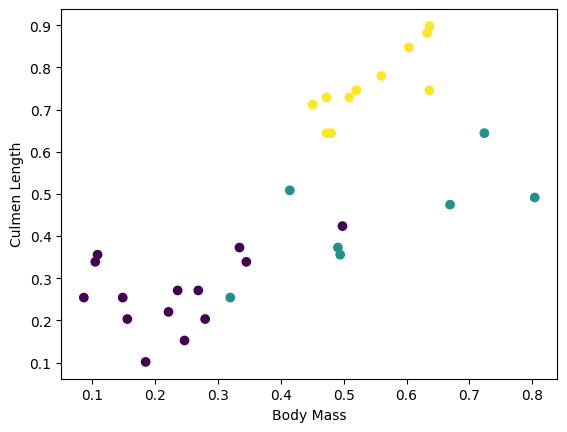

In [8]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

## 単純な線形モデルを構築する

### なぜモデルか？

*[モデル](https://developers.google.com/machine-learning/crash-course/glossary#model)*は、特徴量とラベルの関係です。ペンギンの分類問題においては、このモデルは体重、フリッパー、および嘴峰の測定値、および予測されるペンギンの種の関係を定義しています。単純なモデルは、数行の代数で記述することは可能ですが、複雑な機械学習モデルにはパラメータの数も多く、要約が困難です。

機械学習を*使用せずに*、4 つの特徴量とペンギンの種の関係を判定することはできるのでしょうか。つまり、従来のプログラミング手法（多数の条件ステートメントを使用するなど）を使って、モデルを作成できるのでしょうか。おそらく、体重と嘴峰の測定値の関係を特定できるだけの長い時間を費やしてデータセットを分析すれば、特定の種に絞ることは可能かもしれません。これでは、複雑なデータセットでは不可能でなくとも困難極まりないことでしょう。適した機械学習アプローチであれば、*ユーザーに代わってモデルを判定*することができます。代表的なサンプルを適確な機械学習モデルタイプに十分にフィードすれば、プログラムによって関係を見つけ出すことができます。

### モデルの選択

次に、トレーニングするモデルの種類を選択する必要があります。選択できる種類は多数あり、最適な種類を 1 つ選ぶにはそれなりの経験が必要となります。このチュートリアルでは、ニューラルネットワークを使用して、ペンギンの分類問題を解決することにします。[*ニューラルネットワーク*](https://developers.google.com/machine-learning/glossary/#neural_network)は、特徴量とラベルの複雑な関係を見つけ出すことができます。非常に構造化されたグラフで、1 つ以上の[*非表示レイヤー*](https://developers.google.com/machine-learning/glossary/#hidden_layer)で編成されており、各非表示レイヤーは 1 つ以上の[*ニューロン*](https://developers.google.com/machine-learning/glossary/#neuron)で構成されています。ニューラルネットワークにはいくつかのカテゴリがありますが、このプログラムでは、Dense または[*全結合のニューラルネットワーク*](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)を使用します。このネットワークでは、1 つのレイヤーのニューロンが前のレイヤーの*すべての*ユーロんから入力接続を受け取ります。たとえば、図 2 では、1 つの入力レイヤー、2 つの非表示レイヤー、および 1 つの出力レイヤーで構成される Dense ニューラルネットワークが示されています。

<table>
  <tr><td>     <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png" alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">   </td></tr>
  <tr><td align="center">     <b>図2.</b> 特徴量と隠れ層、予測をもつニューラルネットワーク<br>{nbsp}   </td></tr>
</table>

図 2 のモデルをトレーニングし、ラベルなしのサンプルをフィードすると、このペンギンが特定のペンギン種であるという尤度によって 3 つの予測が生成されます。この予測は[*推論*](https://developers.google.com/machine-learning/crash-course/glossary#inference)と呼ばれます。この例では、出力予測の和は 1.0 です。図 2 の場合、この予測は、*アデリー*は `0.02`、*ヒゲペンギン*は `0.95`、*ジェンツー*は `0.03` となります。つまり、モデルは、95% の確率で、ラベル無しのサンプルペンギンは*ヒゲペンギン*であると予測していることになります。

### Keras を使ったモデル構築

TensorFlow の [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API は、モデルと層を作成するためのおすすめの方法です。Keras がすべてを結びつけるという複雑さを引き受けてくれるため、モデルや実験の構築がかんたんになります。

`tf.keras.Sequential` モデルは、レイヤーの線形スタックです。コンストラクタはレイヤーインスタンスのリスト（この場合は 2 つの `tf.keras.layers.Dense` レイヤー、各レイヤーの 10 個のノード、ラベルの予測である 3 つのノードを持つ出力レイヤー）を取ります。最初のレイヤーの `input_shape` パラメータはデータセットの特徴量の数に対応しており、必須です。

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

[*活性化関数(activation function)*](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)  は、そのレイヤーの各ノードの出力の形を決定します。この関数の非線形性は重要であり、それがなければモデルは 1層しかないものと等価になってしまいます。[利用可能な活性化関数](https://www.tensorflow.org/api_docs/python/tf/keras/activations) はたくさんありますが、隠れ層では [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) が一般的です。

理想的な隠れ層の数やニューロンの数は問題やデータセットによって異なります。機械学習のさまざまな側面と同様に、ニューラルネットワークの最良の形を選択するには、知識と経験の両方が必要です。経験則から、一般的には隠れ層やニューロンの数を増やすとより強力なモデルを作ることができますが、効果的に訓練を行うためにより多くのデータを必要とします。

### モデルを使用する

それでは、このモデルが特徴量のバッチに対して何を行うかを見てみましょう。

In [10]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.33113486,  0.06862736, -0.15201251],
       [-0.16317835,  0.0856431 , -0.05696829],
       [-0.44663656,  0.10232535, -0.20126438],
       [-0.2882833 ,  0.0595708 , -0.14027017],
       [-0.31192848,  0.0247557 , -0.18217248]], dtype=float32)>

ご覧のように、サンプルのそれぞれは、各クラスの [ロジット(logit)](https://developers.google.com/machine-learning/crash-course/glossary#logits) 値を返します。

これらのロジット値を各クラスの確率に変換するためには、 [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 関数を使用します。

In [11]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.27117634, 0.40445137, 0.32437223],
       [0.29458827, 0.37781328, 0.3275985 ],
       [0.24940445, 0.4318325 , 0.31876305],
       [0.27967694, 0.3960297 , 0.3242933 ],
       [0.28257787, 0.39569286, 0.3217292 ]], dtype=float32)>

クラスに渡って `tf.math.argmax` を取ると、クラスのインデックスの予測を得られますが、モデルはまだトレーニングされていないため、これは良い予測ではありません。

In [12]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


## モデルの訓練

[*訓練(Training)*](https://developers.google.com/machine-learning/crash-course/glossary#training) は、機械学習において、モデルが徐々に最適化されていく、あるいはモデルがデータセットを*学習する*段階です。目的は、見たことのないデータについて予測を行うため、訓練用データセットの構造を十分に学習することです。訓練用データセットを学習*しすぎる*と、予測は見たことのあるデータに対してしか有効ではなく、一般化できません。この問題は [*過学習(overfitting)*](https://developers.google.com/machine-learning/crash-course/glossary#overfitting) と呼ばれ、問題の解き方を理解するのではなく答えを丸暗記するようなものです。

ペンギンの分類問題は、[*教師あり機械学習*](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)の例であり、モデルはラベルを含むサンプルからトレーニングされています。サンプルにラベルを含まない場合は、[*教師なし機械学習*](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)と呼ばれ、モデルは通常、特徴量からパターンを見つけ出します。

### 損失と勾配関数を定義する

トレーニングと評価の段階では、モデルの[*損失*](https://developers.google.com/machine-learning/crash-course/glossary#loss)を計算する必要があります。これは、モデルの予測がどれくらい目標から外れているかを測定するものです。言い換えると、モデルのパフォーマンスがどれくらい劣っているかを示します。この値を最小化または最適化することが望まれます。

モデルは、モデルのクラスの確率予測と目標のラベルを取り、サンプル間の平均的な損失を返す  `tf.keras.losses.SparseCategoricalCrossentropy` 関数を使用して損失を計算します。

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.1423850059509277


[tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) コンテキストを使って、モデルを最適化する際に使われる [*勾配(gradients)*](https://developers.google.com/machine-learning/crash-course/glossary#gradient) を計算しましょう。

In [15]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### オプティマイザの作成

[*オプティマイザ*](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)は、`loss` 関数を最小化するために、計算された勾配をモデルのパラメータに適用します。損失関数は、曲面（図 3 を参照）として考えることができ、その周辺を探りながら最低ポイントを見つけることができます。勾配は最も急な上昇に向かってポイントするため、逆方向に進んで曲面を下方向に移動します。バッチごとに損失と勾配を対話的に計算することで、トレーニング中にモデルの調整を行うことができます。モデルは徐々に、重みとバイアスの最適な組み合わせを見つけて損失を最小化できるようになります。損失が低いほど、モデルの予測が最適化されます。

<table>
  <tr><td>     <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%" alt="Optimization algorithms visualized over time in 3D space.">   </td></tr>
  <tr><td align="center">     <b>図3.</b> 3次元空間における最適化アルゴリズムの時系列可視化。<br>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)   </td></tr>
</table>

TensorFlow には、トレーニングに使用できる多数の最適化アルゴリズムが用意されています。このチュートリアルでは、[*確率的勾配降下法*](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)（SGD）アルゴリズムを実装する `tf.keras.optimizers.SGD` を使用しています。`learning_rate` パラメータは、曲面を下降するイテレーションごとに取るステップサイズを設定します。このレートは、一般的により良い結果を達成できるように調整する[*ハイパーパラメータ*](https://developers.google.com/machine-learning/glossary/#hyperparameter)です。

オプティマイザを `0.01` の[*学習率*](https://developers.google.com/machine-learning/glossary#learning-rate)でインスタンス化します。これはトレーニングのイテレーションごとに、勾配が操作するスカラー値です。

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

次に、このオブジェクトを使用して、1 つの最適化ステップを計算します。

In [17]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.1423850059509277


Step: 1,         Loss: 1.1399683952331543


### 訓練ループ

すべての部品が揃ったので、モデルの訓練ができるようになりました。訓練ループは、モデルにデータセットのサンプルを供給し、モデルがよりよい予測を行えるようにします。下記のコードブロックは、この訓練のステップを構成します。

1. *epoch（エポック）* をひとつずつ繰り返します。エポックとは、データセットをひととおり処理するということです。
2. エポック内では、訓練用の `Dataset（データセット）` のサンプルひとつずつから、その *features（特徴量）* (`x`) と *label（ラベル）* (`y`) を取り出して繰り返し処理します。
3. サンプルの特徴量を使って予測を行い、ラベルと比較します。予測の不正確度を測定し、それを使ってモデルの損失と勾配を計算します。
4. `optimizer` を使って、モデルのパラメータを更新します。
5. 可視化のためにいくつかの統計量を記録します。
6. これをエポックごとに繰り返します。

`num_epochs` 変数は、データセットコレクションをループする回数です。以下のコードでは、`num_epochs` は 201 に設定されているため、このトレーニングループは 201 回実行します。直感に反し、モデルをより長くトレーニングしても、モデルがさらに最適化されることは保証されません。`num_epochs` は、ユーザーが調整できる[*ハイパーパラメータ*](https://developers.google.com/machine-learning/glossary/#hyperparameter)です。通常、適切な数値を選択するには、経験と実験の両方が必要です。

In [18]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.140, Accuracy: 18.727%


Epoch 050: Loss: 0.716, Accuracy: 79.026%


Epoch 100: Loss: 0.462, Accuracy: 80.899%


Epoch 150: Loss: 0.332, Accuracy: 90.637%


Epoch 200: Loss: 0.234, Accuracy: 95.880%


または、組み込みの Keras [`Model.fit(ds_train_batch)`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) メソッドを使用して、モデルをトレーニングすることもできます。 

### 時間の経過に対する損失関数の可視化

モデルのトレーニングの進行状況を出力することは役立ちますが、TensorFlow に同梱された [TensorBoard](https://www.tensorflow.org/tensorboard) という可視化とメトリクスツールを使って進行状況を可視化することもできます。この単純な例では、`matplotlib` モジュールを使用して基本的なグラフを作成できます。

これらのグラフを解釈するには経験が必要ですが、一般的に、*損失*の減少と*精度*の上昇に注目できます。

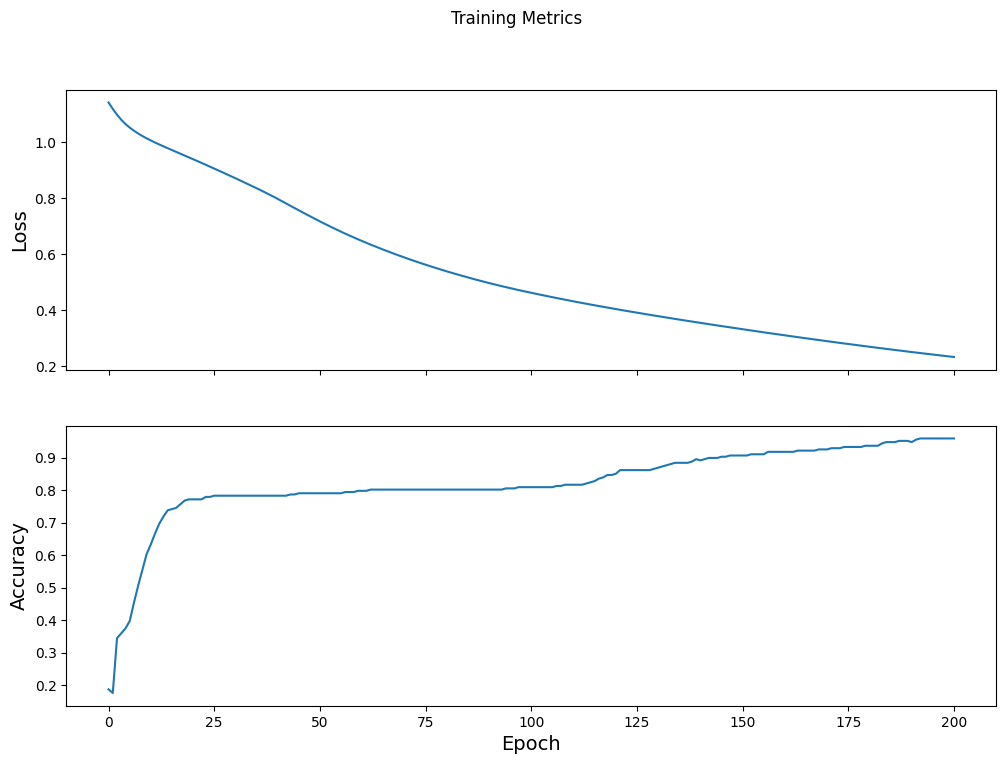

In [19]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## モデルの有効性評価

モデルがトレーニングが完了したため、パフォーマンスの統計を取得できるようになりました。

*評価*とは、モデルがどれくらい効果的に予測を立てられるかを判定することです。ペンギンの分類においてモデルの有効性を判定するには、測定値をモデルに渡し、それが表すペンギンの種をモデルに問います。次に、モデルの予測を実際のラベルと比較します。たとえば、入力サンプルの半数で正しい種を選択したモデルであれば、その[*精度*](https://developers.google.com/machine-learning/glossary/#accuracy)は `0.5` となります。図 4 には、わずかに有効性の高いモデルが示されており、80% の精度で、5 回の予測の内 4 回が正解となっています。

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4">
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">サンプルの特徴量</th>
    <th colspan="1">ラベル</th>
    <th colspan="1">モデルの予測値</th>
  </tr>
  <tr>
    <td>5.9</td>
<td>3.0</td>
<td>4.3</td>
<td>1.5</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td>
<td>3.1</td>
<td>5.4</td>
<td>2.1</td>
<td align="center">2</td>
<td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td>
<td>3.3</td>
<td>1.7</td>
<td>0.5</td>
<td align="center">0</td>
<td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td>
<td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td>
<td>2.5</td>
<td>4.0</td>
<td>1.3</td>
<td align="center">1</td>
<td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">     <b>図 4.</b> 80% 正確なペンギンの分類器<br> </td></tr>
</table>

### テストセットをセットアップする

モデルの評価はモデルの訓練と同様です。もっとも大きな違いは、サンプルが訓練用データセットではなく[*テスト用データセット(test set)*](https://developers.google.com/machine-learning/crash-course/glossary#test_set) からのものであるという点です。モデルの有効性を正しく評価するには、モデルの評価に使うサンプルは訓練用データセットのものとは違うものでなければなりません。

penguin データセットには、別途テストデータセットが用意されていないため、当然、前述のデータセットのダウンロードセクションのデータセットにもテストデータセットはありません。そこで、元のデータセットをテストデータセットとトレーニングデータセットに分割します。評価には、`ds_test_batch` データセットを使用してください。

### テスト用データセットでのモデルの評価

トレーニングの段階とは異なり、このモデルはテストデータの 1 つの[エポック](https://developers.google.com/machine-learning/glossary/#epoch)しか評価しません。次のコードはテストセットの各サンプルを反復し、モデルの予測を実際のラベルに比較します。この比較は、テストセット全体におけるモデルの精度を測定するために使用されます。

In [20]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 95.522%


また、`model.evaluate(ds_test, return_dict=True)` Keras 関数を使用して、テストデータセットの精度情報を取得することもできます。 

たとえば、最後のバッチを調べて、モデルの予測が通常正しい予測であることを観察することができます。


In [21]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(7, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 0],
       [2, 2],
       [0, 0]])>

## 訓練済みモデルを使った予測

モデルをトレーニングし、ペンギンの種を分類する上でモデルが良好であることを「証明」しました（ただし、完璧ではありません）。では、トレーニング済みのモデルを使用して、[*ラベルなしのサンプル*](https://developers.google.com/machine-learning/glossary/#unlabeled_example)、つまりラベルのない特徴量を含むサンプルで予測を立ててみましょう。

実際には、ラベルなしのサンプルは、アプリ、CSV ファイル、データフィードといったさまざまなソースから取得される場合がありますが、このチュートリアルでは、ラベルなしのサンプルを手動で提供して、それぞれのラベルを予測することにします。ラベル番号は、次のように指定されていることを思い出してください。

- `0`: アデリーペンギン
- `1`: ヒゲペンギン
- `2`: ジェンツーペンギン

In [22]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Adélie (77.2%)
Example 1 prediction: Gentoo (97.7%)
Example 2 prediction: Chinstrap (67.9%)
